In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.2.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

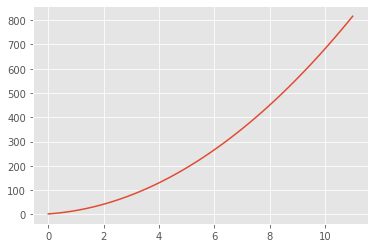

In [239]:
import numpy as np
import random 
import matplotlib.pyplot as plt


# Training data
X = np.linspace(0,11,num=100)
y = np.asarray([6*x**2 + 8*x + 2 for x in X]) # y = 6x^2 + 8x + 2

plt.plot(X,y)

In [240]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [230]:
len(X_test)

30

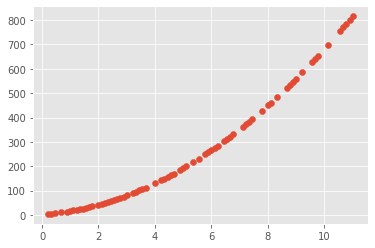

In [241]:
plt.scatter(X_train,y_train)

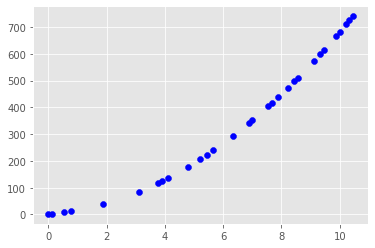

In [242]:
plt.scatter(X_test,y_test,c='blue')

In [316]:
# Trainable variables
theta=[tf.Variable(np.random.normal(0,1), trainable=True) for i in range(3)]
# Loss function

def loss(real_y, pred_y):
    return tf.sqrt(tf.reduce_mean((real_y - pred_y)**2))

# Step function
def step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Make prediction
        pred_y=theta[0]*real_x**2 + theta[1]*real_x + theta[2]
        # Calculate loss
        poly_loss = loss(real_y, pred_y)
    
    # Calculate gradients
    grads = tape.gradient(poly_loss, theta)
    # Update variables
    for par,grad in zip(theta,grads):
        par.assign_sub(grad * 0.001)
    return poly_loss.numpy()

# Training loop
for i in range(10000):
    iter_loss=step(X_train, y_train)
    if i%1000==0:
        print('iteration : {0}, loss : {1} '.format(i,iter_loss))
print('------------------------------------')
print(f'y ≈ {theta[0].numpy()}x^2 + {theta[1].numpy()}x + {theta[0].numpy()}')


iteration : 0, loss : 395.6866455078125 
iteration : 1000, loss : 13.10839557647705 
iteration : 2000, loss : 10.047175407409668 
iteration : 3000, loss : 6.988889694213867 
iteration : 4000, loss : 3.939964532852173 
iteration : 5000, loss : 1.3382169008255005 
iteration : 6000, loss : 1.3400605916976929 
iteration : 7000, loss : 1.3400665521621704 
iteration : 8000, loss : 1.340060830116272 
iteration : 9000, loss : 1.34004545211792 
------------------------------------
y ≈ 5.997419834136963x^2 + 7.704699993133545x + 5.997419834136963


La solucion del problema de estimacion de coeficientes puede ser calculada en forma cerrada mediante minimos cuadrados (https://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html)

In [317]:
X_mat=np.vstack([X_train**2,X_train**1,X_train**0])
inv_mat=np.linalg.inv(np.matmul(X_mat,X_mat.T))
theta_hat=np.matmul(inv_mat,np.matmul(X_mat,y_train))
print('y ≈ {0:0.2f}x^2 + {1:0.2f}x + {2:0.2f}'.format(*theta_hat.tolist()))

y ≈ 6.00x^2 + 8.00x + 2.00


In [308]:
y_pred=[]
for x in X_test:
    y_hat=theta[0]*x**2 + theta[1]*x + theta[2]
    y_pred.append(y_hat.numpy())

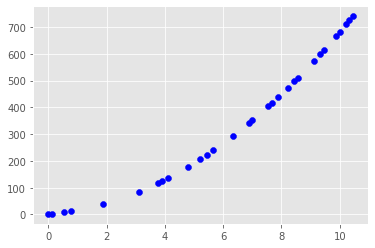

In [309]:
plt.scatter(X_test,y_test,c='blue')

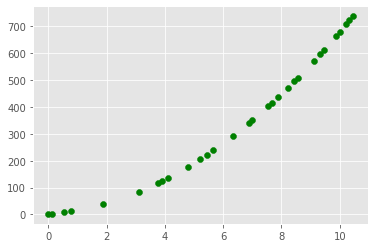

In [314]:
plt.scatter(X_test,y_pred,c='green')

# Redes Neuronales Tensorflow

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop,SGD

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train=x_train.reshape((-1,784))
x_test=x_test.reshape((-1,784))
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [15]:
from tensorflow.keras import regularizers

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense(10, activation='softmax',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-2)))
model.summary()

epochs=100
sgd = SGD(lr=0.01, decay=0, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 0.7032 - accuracy: 0.8595 - val_loss: 0.4810 - val_accuracy: 0.9073
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4497 - accuracy: 0.9116 - val_loss: 0.4049 - val_accuracy: 0.9208
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3979 - accuracy: 0.9194 - val_loss: 0.3756 - val_accuracy: 0.9237
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3678 -

469/469 [==============================] - 1s 2ms/step - loss: 0.1778 - accuracy: 0.9678 - val_loss: 0.1804 - val_accuracy: 0.9666
Epoch 54/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1779 - accuracy: 0.9681 - val_loss: 0.1823 - val_accuracy: 0.9642
Epoch 55/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1768 - accuracy: 0.9681 - val_loss: 0.1821 - val_accuracy: 0.9650
Epoch 56/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1754 - accuracy: 0.9682 - val_loss: 0.1828 - val_accuracy: 0.9636
Epoch 57/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1745 - accuracy: 0.9686 - val_loss: 0.1824 - val_accuracy: 0.9657
Epoch 58/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1740 - accuracy: 0.9682 - val_loss: 0.1784 - val_accuracy: 0.9654
Epoch 59/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1730 - accuracy: 0.9690 - val_loss: 0.1741 - val_accuracy: 0.9667
Epoch

In [16]:
print(score)

[0.1524730771780014, 0.972100019454956]


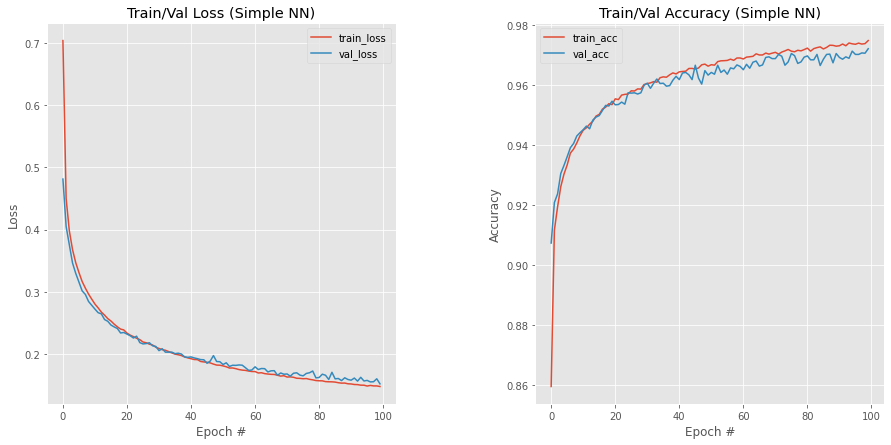

In [17]:
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0, epochs)
plt.style.use("ggplot")

fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(1, 2, 1)
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Train/Val Loss (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Train/Val Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [75]:
y_pred_nn=model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.97      0.98      0.97      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.96      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.95      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.95      0.94      0.94       974
           9       0.96      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



Confusion matrix, without normalization


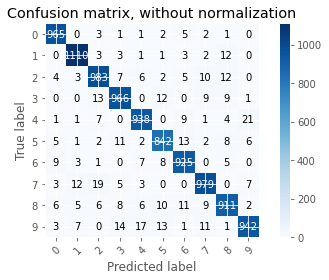

In [81]:
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1),classes=np.arange(num_classes))